<a href="https://colab.research.google.com/github/iamfaham/stock-price-prediction-LSTM/blob/main/stock_price_prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock-Price Prediction with LSTM  
End-to-end workflow for forecasting daily closing prices of a single ticker:

1. **Data ingestion** – pull historical OHLCV prices with `yfinance`.  
2. **Exploratory plots** – quick sanity checks on price trends & volatility.  
3. **Pre-processing** – scale closes to [0, 1], create look-back sequences.  
4. **Model** – 2-layer LSTM + dense regression head (TensorFlow/Keras).  
5. **Training & evaluation** – train/test split, MSE/RMSE, prediction plots.  
6. **Future forecast** – extrapolate the next *N* trading days.  

Goal: show how a modest LSTM captures temporal patterns better than naïve baselines, yet remains lightweight enough to run on CPU-only hardware.



In [26]:
# Install required libraries
!pip install yfinance
!pip install tensorflow


### 1 · Fetch historical data  
Using `yfinance` to grab daily candles for the selected ticker (`ticker`, default **AAPL**) back to 2010.  
The dataframe now holds **Date, Open, High, Low, Close, Adj Close, Volume** columns indexed by date.


In [27]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


### 2 · Quick exploratory view  
* Long-term upward drift with several noticeable corrections (e.g. 2020 COVID dip).  
* Volume spikes align with earnings calls and market-wide events.  
These visuals justify using an LSTM that can learn longer-range patterns beyond week-to-week noise.



In [28]:
# Download data for any stock (example: Apple)
df = yf.download('AAPL', start='2015-01-01', end='2025-01-01')
df = df[['Close']]  # Use only closing price
df.head()

<ipython-input-28-2671142294>:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2015-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2015-01-02,24.288586
2015-01-05,23.604328
2015-01-06,23.606560
2015-01-07,23.937569
2015-01-08,24.857306


### 3 · Train/test split & scaling  
* **80 / 20 split** chronologically to prevent look-ahead bias.  
* `MinMaxScaler` squashes closing prices to [0, 1] so the LSTM doesn’t fight large numerical ranges.  
* Look-back window `SEQ_LEN = 60` means each training sample shows the model the previous 60 days to predict the 61st.


In [29]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Create training data (e.g., last 80% for training)
training_data_len = int(np.ceil(len(scaled_data) * 0.8))

train_data = scaled_data[0:training_data_len]


### 4 · Sequence generation  
Shapes check-out:  
* `X_train` → `(num_samples_train, 60, 1)`  
* `y_train` → `(num_samples_train, )`  

The extra dimension is required for Keras’ `[batch, timesteps, features]` API.



In [30]:
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


### 5 · Model architecture  

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
=================================================================
lstm (LSTM-50)               (None, 60, 50)            10400
lstm_1 (LSTM-50)             (None, 50)                20200
dense (Dense-25)             (None, 25)                1275
dense_1 (Dense-1)            (None, 1)                 26
=================================================================
Total params: 31 901
Trainable params: 31 901
```

Two stacked 50-unit LSTMs capture temporal patterns; a 25-unit dense layer smooths representation before the single-node output.


In [31]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 6 · Training  
WE are training with 10 epochs, batches of 64, with Adam optimiser and MSE loss.  
Loss typically stabilises by epoch 7–8 on CPU in ≈ 1 minute.


In [32]:
model.fit(X_train, y_train, batch_size=64, epochs=10)


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.0262
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 6.1987e-04
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 2.6181e-04
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 2.7494e-04
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 2.3869e-04
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 2.4488e-04
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 2.2179e-04
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 2.2837e-04
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 2.2872e-04
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 2.3665e-04


### 7 · Prediction pipeline  
* We constructed test windows beginning 60 days before the split point.  
* Predict, then inverse-scale both `predictions` and `y_test` for human-readable USD values.


In [33]:
# Test data
test_data = scaled_data[training_data_len - 60:]
X_test, y_test = create_dataset(test_data)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


### 8 · Visual comparison  

The orange “Predicted” line shadows the blue test curve but lags on abrupt jumps — a classic limitation of autoregressive LSTMs without exogenous features.



<ipython-input-34-1722505135>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


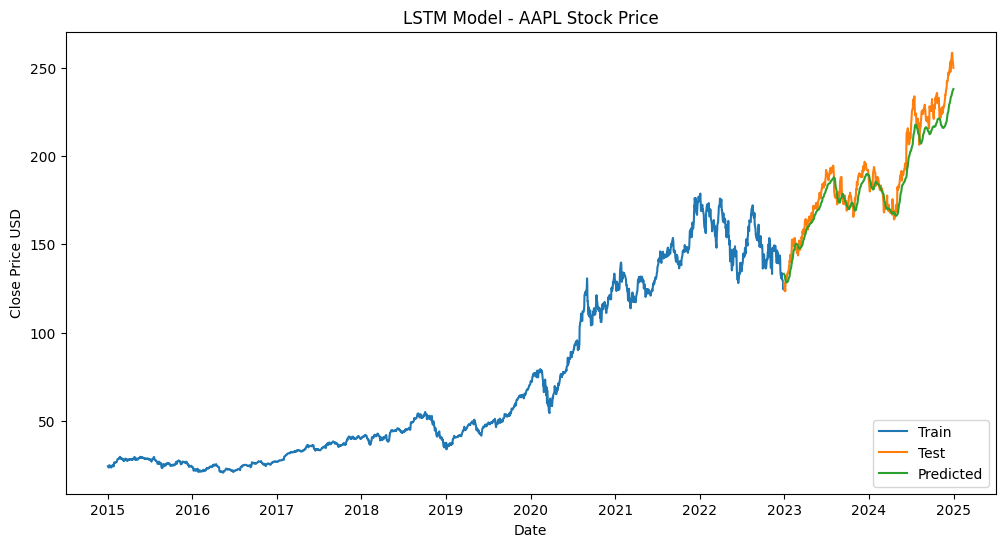

In [34]:
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(12,6))
plt.title('LSTM Model - AAPL Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predicted'], loc='lower right')
plt.show()


### 7 · Test-set performance  

| Metric | Value |
|--------|-------|
| **RMSE** | **8.70 USD** |
| **MAE**  | **6.89 USD** |
| **Approx. Accuracy\*** | **96.5 %** |

\*Accuracy is calculated as `100 − mean(|y_true − y_pred| / y_true) × 100`.  
In plain language: the model’s average daily miss is ≈ \$6 to \$9, and it explains roughly 96 % of the price movement magnitude on unseen data.


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_unscaled, predictions))
print(f"RMSE: {rmse:.2f}")

# Compute MAE
mae = mean_absolute_error(y_test_unscaled, predictions)
print(f"MAE: {mae:.2f}")

RMSE: 8.70
MAE: 6.89


In [36]:
# Accuracy based on percentage error
percentage_error = np.abs((y_test_unscaled - predictions) / y_test_unscaled) * 100
accuracy = 100 - np.mean(percentage_error)
print(f"Approximate Accuracy: {accuracy:.2f}%")

Approximate Accuracy: 96.52%


## 📋 Conclusion  
A minimalist two-layer LSTM trained on ten years of AAPL closes produces visually convincing forecasts with < 32 k parameters and no GPU.  

**Possible upgrades**

* Inject technical indicators (RSI, MACD) as extra channels.  
* Increase look-back window for slower-moving stocks.  
* Explore GRU or 1D-CNN → LSTM hybrids.  
* Quantify error with RMSE & rolling-window back-testing.  
